In [1]:
import pandas as pd
from darts import TimeSeries

df = pd.read_csv('../data/30days_data_17_Apr_2024.csv')
features_list = ["sa1.price", "sa1.demand", "sa1.temperature", "Timestamp"]
fh=36

df = df[features_list]
df.columns = ["price", "demand", "temperature", "timestamp"]
df = df[:-6]
df['temperature'] = df['temperature'].ffill()
df["price"] = df["price"].astype(float)
df["demand"] = df["demand"].astype(float)
df["temperature"] = df["temperature"].astype(float)

# set datetime index timestamp, dart format issues
def set_index(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.tz_localize(None)
    df.set_index(keys='timestamp', inplace=True, drop=True)
    return df
df = set_index(df)

series = TimeSeries.from_dataframe(df)
train, after = series.split_after(7000)
# split after into val (until last 36 rows) and test (last 36 rows)
val, test = after.split_after(1603)
print(len(val), len(test))

1604 36


/var/folders/65/s5nhg1rn5kg7gx9qh7fb2lc00000gn/T/ipykernel_65901/3125302046.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.tz_localize(None)


In [2]:
y_train = train['price']
X_train = train.drop_columns('price')
# not actually validation set, but using it as past covariates for predicting test
y_val = val['price']
X_val = val.drop_columns('price')
# test has length for forecast horizon = 36 (3 hours)
y_test = test['price']
X_test = test.drop_columns('price')

In [3]:
from darts.models import XGBModel

model = XGBModel(
    lags=12,
    lags_past_covariates=12,
    output_chunk_length=36,
)
model.fit(series=y_train, past_covariates=X_train)

/Users/victorwkb/projects/gbh-skvalp/venv/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


XGBModel(lags=12, lags_past_covariates=12, lags_future_covariates=None, output_chunk_length=36, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [4]:
y_pred = model.predict(series=y_val, past_covariates=X_val, n=fh)
# 0.0s on my screen

<Axes: xlabel='timestamp'>

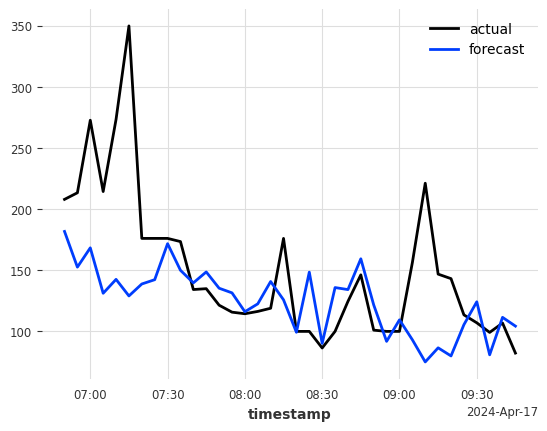

In [5]:
import matplotlib.pyplot as plt

plt.figure()
# plot first 36 values of y_test
y_test.plot(label='actual')
y_pred.plot(label='forecast')